In [1]:
import numpy as np
import cv2
import os
import yaml
import pickle
from glob import glob
import matplotlib.pyplot as plt

In [2]:
#make matplotlib figures appear inline in the notebook
#rather than in a new window.
%matplotlib inline
# set default size of plots
plt.rcParams['figure.figsize'] = (12.0, 10.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

#print OpenCV version
print ("OpenCV Version : %s " % cv2.__version__)

OpenCV Version : 3.3.1 


In [3]:
# the notebook will reload external python modules;
%load_ext autoreload
%autoreload 2

In [4]:
#source video
video_capture = cv2.VideoCapture('../../../Public/cam_calibration/DJI2_cam/DJI00884.MP4')

In [5]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 0.001)

In [6]:
#chessboard pattern
pattern_size = (9, 6) #number of points
square_size = 58.0
pattern_points = np.zeros((np.prod(pattern_size), 3), np.float32)
pattern_points[:, :2] = np.indices(pattern_size).T.reshape(-1, 2)

In [7]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((np.prod(pattern_size), 3), np.float32)       
objp[:,:2] = np.indices(pattern_size).T.reshape(-1, 2)
objp *= square_size

In [8]:
#initializing
frame_step = 20 #read at each 'frame_step' frames
h, w = 0, 0
i = -1
retval = True

Searching for chessboard in frame 0...
ok


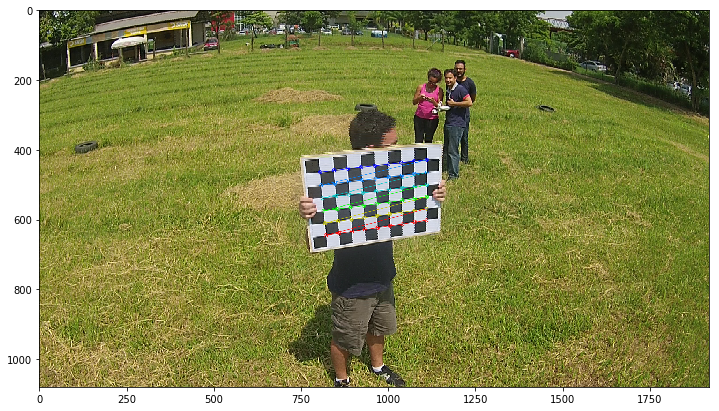

Searching for chessboard in frame 20...
ok


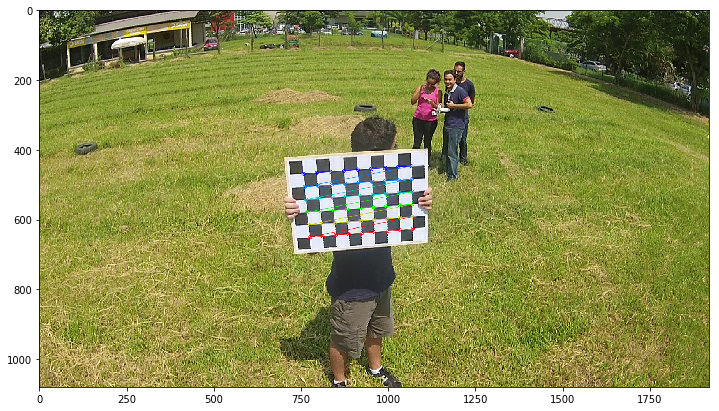

Searching for chessboard in frame 40...
ok


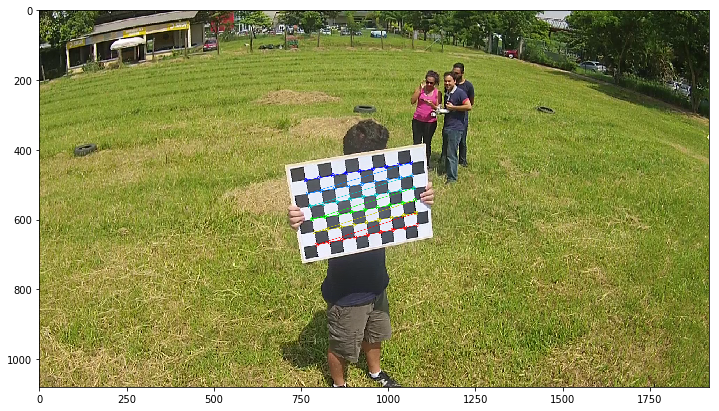

Searching for chessboard in frame 60...
ok


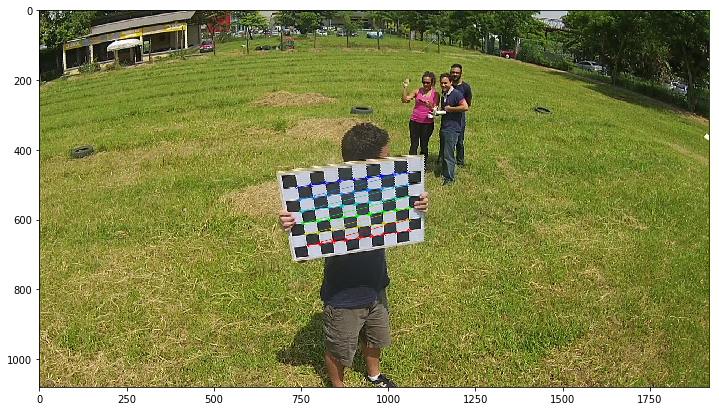

Searching for chessboard in frame 80...
not found
Searching for chessboard in frame 100...
not found
Searching for chessboard in frame 120...
ok


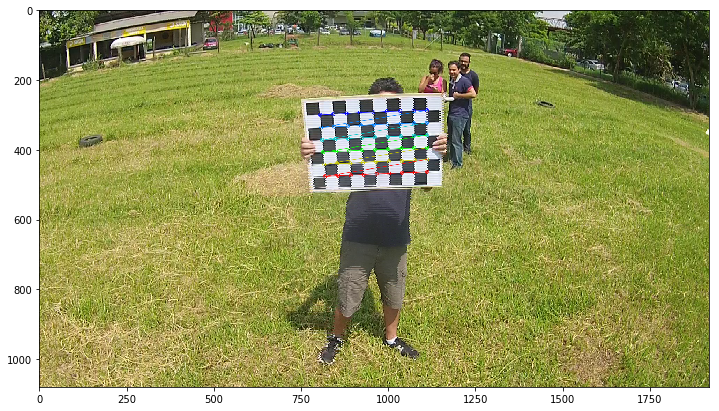

Searching for chessboard in frame 140...
not found
Searching for chessboard in frame 160...
not found
Searching for chessboard in frame 180...
not found
Searching for chessboard in frame 200...
not found
Searching for chessboard in frame 220...
not found
video capture failed!


In [9]:
# Arrays to store object points and image points from all the images.
obj_points = [] # 3d point in real world space
img_points = [] # 2d points in image plane.

while retval:
    i+=1
    
    #extracting frame
    retval, img = video_capture.read()
    if not retval:
        print('video capture failed!')
        break
    
    #read at each frame_step    
    if i % frame_step != 0:
        continue
        
    print('Searching for chessboard in frame ' + str(i) + '...')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    h, w = img.shape[:2]
    
    #Find chessboard corners
    found, corners = cv2.findChessboardCorners(gray,
                                               pattern_size,
                                               cv2.CALIB_CB_FILTER_QUADS)
    
    # If found, add object points, image points (after refining them)
    if found:
        corners2 = cv2.cornerSubPix(gray,
                                    corners,
                                    (11, 11), (-1, -1),
                                    criteria)
    
    #If not found, go to next frame
    if not found:
        print('not found')
        continue
    
    img_points.append(corners2)
    obj_points.append(pattern_points)
    
    print('ok')
    
    # Draw and display the corners
    img = cv2.drawChessboardCorners(cv2.cvtColor(img,cv2.COLOR_BGR2RGB), 
                                    pattern_size,
                                    corners2,
                                    found)
    plt.imshow(img)
    plt.show()        

## Calibration

In [10]:
print('\nPerforming calibration...')
rms, camera_matrix, dist_coefs, rvecs, tvecs = cv2.calibrateCamera(obj_points,
                                                                   img_points,
                                                                   (w, h),
                                                                   None,
                                                                   None)
camera_matrix


Performing calibration...


array([[1.23186011e+03, 0.00000000e+00, 9.89705757e+02],
       [0.00000000e+00, 1.23133172e+03, 5.46056624e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

## Undistortion

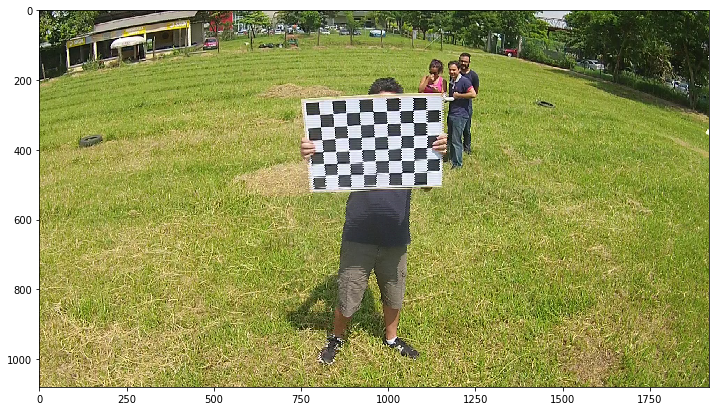

In [11]:
# http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html
#choosing a frame at random
img = cv2.imread('../../../Public/cam_calibration/DJI2_cam/frames_DJI00884/frame120.jpeg')

h,  w = img.shape[:2]
#efine the camera matrix based on a free scaling parameter
#using cv2.getOptimalNewCameraMatrix()
new_camera_matrix, roi=cv2.getOptimalNewCameraMatrix(camera_matrix,
                                                     dist_coefs,
                                                     (w,h),
                                                     1,
                                                     (w,h))
#display image
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show() 

* Using cv2.undistort()

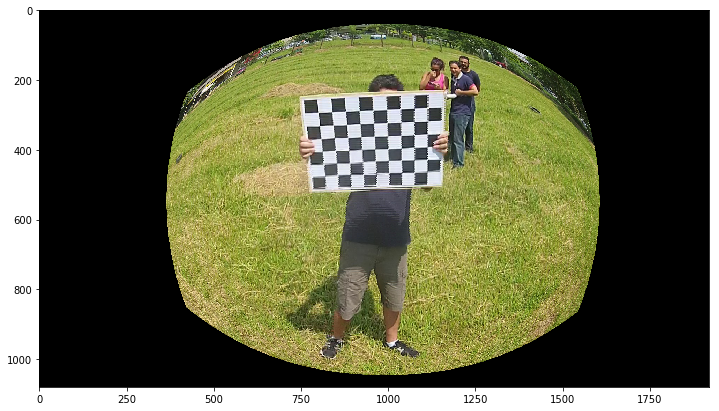

In [14]:
# undistort
#dst = cv2.undistort(img, camera_matrix, dist_coefs, None, new_camera_matrix)
dst = cv2.undistort(img, camera_matrix, dist_coefs)#, None, new_camera_matrix)

# crop the image
x,y,w,h = roi
#dst = dst[y:y+h, x:x+w, :]
#display image
plt.imshow(cv2.cvtColor(dst,cv2.COLOR_BGR2RGB))
plt.show() 

uh-oh! something seems wrong here!

* Using remapping

In [15]:
# undistort
mapx,mapy = cv2.initUndistortRectifyMap(camera_matrix,
                                        dist_coefs,
                                        None,
                                        new_camera_matrix,
                                        (w,h),
                                        5)
dst = cv2.remap(img,mapx,mapy,cv2.INTER_LINEAR)

# crop the image
x,y,w,h = roi
#dst = dst[y:y+h, x:x+w]
#display image
#dst

In [16]:
roi

(933, 519, 135, 36)